In [1]:
import pandas as pd
import numpy as np
# Ajouter export FRED_API_KEY="your_api_key" dans fichier .zshrc et .bashrc
# Sinon  ajouter (,api_key="my_api_key") dans .get_series de fonction fred_data
import pyfredapi as pf
import MacroRandomForest as MRF
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
# Use matplotlib's 'classic' style, set figure facecolor to white
plt.style.use('classic')
plt.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['figure.figsize'] = [20, 9]

global start_date, end_date, window_dates
start_date = np.datetime64('1980-01-01')
end_date = np.datetime64('2023-12-01')
current_date = start_date
window_dates = []

while current_date <= end_date:
    window_dates.append(current_date)
    current_date = np.datetime64(current_date, 'M') + np.timedelta64(1, 'M')

window_dates = np.array(window_dates, dtype='datetime64[M]').tolist()

gdpm = pd.read_excel("US-Monthly-GDP-History-Data.xlsx",sheet_name="Data")
gdpm.drop(columns=['Unnamed: 0'],inplace=True)
gdpm.set_index('Date',inplace=True)

- https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579
- https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
- https://en.wikipedia.org/wiki/Singular_spectrum_analysis
- https://stats.stackexchange.com/questions/158281/can-pca-be-applied-for-time-series-data

maths:
- https://online.stat.psu.edu/stat505/lesson/11/11.2

papier:
- https://www.sciencedirect.com/science/article/pii/S2212567116303045?ref=pdf_download&fr=RR-2&rr=83eb76473aced62a

- S&P/Case-Shiller U.S. National Home Price Index (CSUSHPINSA)
#### Rates
- Federal Funds Effective Rate (FEDFUNDS) *x*
- 30-Year Fixed Rate Mortgage Average in the United States (MORTGAGE30US) *x*
- 10-Year Real Interest Rate (REAINTRATREARAT10Y)
- Personal Saving Rate (PSAVERT)
- XXX / Personal Saving (PMSAVE)
- Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10)
#### Economics
- US Monthly GDP (MGDP) Index
> https://www.spglobal.com/marketintelligence/en/mi/products/us-monthly-gdp-index.html
- XXX / Gross Domestic Product (GDP)
- XXX / Real Gross Domestic Product (GDPC1)
- XXX / Leading Indicators OECD: Reference Series: Gross Domestic Product (GDP): Normalised for United States (USALORSGPNOSTSAM)
- XXX / Real Potential Gross Domestic Product (GDPPOT)
- Currency in Circulation (CURRCIR)
- M2 (M2SL)
- Industrial Production: Total Index (INDPRO)
- Unemployment Rate (UNRATE) *x*
- Labor Force Participation Rate (CIVPART)
- Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL) *x*
- XXX /Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average (CPILFESL)
- University of Michigan: Inflation Expectation (MICH)
- Real-time Sahm Rule Recession Indicator (SAHMREALTIME)
- XXX / GDP-Based Recession Indicator Index (JHGDPBRINDX)
- XXX / Deflation Probability (STLPPMDEF)
#### Household
- Personal Consumption Expenditures (PCE)
- XXX / Real Personal Consumption Expenditures (PCEC96)
- Real Disposable Personal Income (DSPIC96) *x*
- Household Estimates (TTLHHM156N)
- XXX / Population Level - 55 Yrs. & over (LNU00024230)
- XXX / Population Level (CNP16OV)
#### Banking
- Total Consumer Credit Owned and Securitized (TOTALSL)
- XXX / Consumer Loans: Credit Cards and Other Revolving Plans, All Commercial Banks (CCLACBW027SBOG)
- Deposits, All Commercial Banks (DPSACBW027SBOG)
#### Housing
- Monthly Supply of New Houses in the United States (MSACSR)
- XXX / New Privately-Owned Housing Units Started: Total Units (HOUST)

In [2]:
REQUEST_LIST = ["CSUSHPINSA","FEDFUNDS","DGS10","MORTGAGE30US","REAINTRATREARAT10Y","PSAVERT",
                  "CURRCIR","M2SL","INDPRO","UNRATE","CIVPART","CPIAUCSL","MICH",
                  "PCE","DSPIC96","TTLHHM156N","TOTALSL","DPSACBW027SBOG","MSACSR"]

def fred_data(L:list):
    x = pd.DataFrame(columns=L, index=window_dates)
    
    with tqdm(total=len(L), ascii=True) as pbar:
        for var in L:
            try:
                y = pf.get_series(series_id=var,observation_start=str(start_date),observation_end=str(end_date),frequency="m")
                y.set_index('date',inplace=True)
                y.drop(columns=["realtime_start","realtime_end"],inplace=True)
                x[var] = y.value
            except:
                None
            pbar.update()
    x['SPREAD'] = x['DGS10'] - x['FEDFUNDS']
    x = x.drop(columns=["FEDFUNDS","DGS10"])
    return x

#TODO: data request
data = fred_data(L=REQUEST_LIST)
data[['GDPn','GDPr']] = gdpm[['GDPn','GDPr']] # Monthly GDP data import
data = data.dropna()

display(data)

100%|##########| 19/19 [00:08<00:00,  2.16it/s]


,CSUSHPINSA,MORTGAGE30US,REAINTRATREARAT10Y,PSAVERT,CURRCIR,M2SL,INDPRO,UNRATE,CIVPART,CPIAUCSL,MICH,PCE,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,MSACSR,SPREAD,GDPn,GDPr
1992-01-01,75.700,8.43,3.198542,9.5,304.146,3381.2,61.4898,7.3,66.3,138.300,2.7,4084.7,7474.8,95776.0,798.98271,2473.1532,5.2,3.00,6315.725062,10177.847909
1992-02-01,75.655,8.76,3.628292,9.8,301.542,3400.0,61.9299,7.4,66.2,138.600,2.6,4099.5,7507.2,95888.0,799.64038,2484.7280,4.9,3.28,6356.503073,10222.868120
1992-03-01,75.814,8.94,3.660265,9.7,302.653,3403.9,62.4490,7.4,66.4,139.100,2.6,4117.0,7513.8,95984.0,799.44211,2495.0398,6.1,3.56,6417.077864,10307.994876
1992-04-01,76.080,8.85,3.789860,9.8,305.007,3399.7,62.9312,7.4,66.5,139.400,3.0,4131.5,7535.0,96309.0,797.65814,2495.1205,6.1,3.75,6443.259544,10314.363367
1992-05-01,76.398,8.67,3.746170,9.8,307.800,3398.6,63.1359,7.6,66.6,139.700,2.9,4158.4,7570.2,96456.0,797.66790,2484.9213,6.0,3.57,6433.810195,10293.428659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,305.365,6.43,1.536904,5.3,2333.155,20820.7,102.9240,3.7,62.6,303.294,4.2,18407.8,16818.5,130190.0,4958.80277,17274.7781,7.2,-1.49,27073.953429,22255.042049
2023-06-01,308.285,6.71,1.060631,4.8,2342.699,20854.5,102.3002,3.6,62.6,303.841,3.3,18485.4,16809.5,130179.0,4971.61099,17316.8828,7.5,-1.33,27191.380434,22314.750969
2023-07-01,310.146,6.84,1.426047,4.4,2340.641,20863.7,103.2166,3.5,62.6,304.348,3.4,18595.4,16808.4,130278.0,4984.85400,17343.2912,7.1,-1.22,27386.299100,22426.221180
2023-08-01,311.519,7.07,1.602095,4.4,2330.824,20825.5,103.2158,3.8,62.8,306.269,3.5,18651.6,16814.6,130287.0,4972.49265,17325.1125,7.9,-1.16,27624.369911,22505.479995


In [3]:
# --- Data Transformation
#TODO: usual transformation for stationarity 
#? "diff_ln" : 100*(log(x_'t') - log(x_'t-12')) = YoY growth rate
#? "diff" : 100*(x_'t' - x_'t-12') = YoY change in ... rate
#? rolling : special case of "MSACSR" : at time t it is the YoY% growth rate between : the number of houses added between (t) and (t)-11 (= over the past year) and the same number but between (t-12) and (t-12)-11 
#? "level" : no change on data

DATA_TRANSFORM = {
"diff_ln":[
"CSUSHPINSA",
"CURRCIR",
"M2SL",
"CPIAUCSL",
"INDPRO",
"PCE",
"DSPIC96",
"TTLHHM156N",
"TOTALSL",
"DPSACBW027SBOG",
"GDPr"
],

"diff":[
"MORTGAGE30US",
"REAINTRATREARAT10Y",
"UNRATE",
"CIVPART"
],

"level":[
"SPREAD",
"PSAVERT",
"MICH" 
],

"rolling":["MSACSR"]
}


def data_treat(df,treatment):
    
    def log_transform(cell_value):
        try:
            return np.log(float(cell_value))
        except (ValueError, TypeError):
            return cell_value
    
    x = pd.DataFrame(index=df.index)
    
    for key in treatment:
        if key=="diff_ln":
            x[treatment[key]] = 100*df[treatment[key]].applymap(log_transform).diff(periods=12)
        elif key=="diff":
            x[treatment[key]] = df[treatment[key]].diff(periods=12)
        elif key=="level":
            x[treatment[key]] = df[treatment[key]]
        else:
            x[treatment[key]] = 100*df[treatment[key]].rolling(12).sum().pct_change(periods=12)
    x = x.dropna()
    return x

df_data = data_treat(df=data,treatment=DATA_TRANSFORM)
VARIABLES_LIST = list(df_data.columns)[1::]
df_data

,CSUSHPINSA,CURRCIR,M2SL,CPIAUCSL,INDPRO,PCE,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,GDPr,MORTGAGE30US,REAINTRATREARAT10Y,UNRATE,CIVPART,SPREAD,PSAVERT,MICH,MSACSR
1993-12-01,2.133645,9.212538,1.443671,2.772180,3.350883,5.270937,1.407186,1.773860,7.125035,1.565067,2.723535,-1.04,-0.789569,-0.9,0.1,2.81,9.0,3.0,-5.546995
1994-01-01,2.332682,9.357181,1.618834,2.421426,3.267621,5.477629,1.715050,0.985836,7.461335,1.746216,2.868937,-0.93,-0.495224,-0.7,0.4,2.70,7.0,2.8,-5.069124
1994-02-01,2.429406,9.836077,1.776483,2.484600,2.851051,6.172477,1.427719,0.994390,7.829006,1.426838,3.278961,-0.53,-0.384616,-0.5,0.4,2.72,6.4,2.8,-6.106870
1994-03-01,2.542614,10.032467,1.985033,2.617229,3.946258,6.525624,2.063207,0.881876,9.118025,0.968924,3.969991,0.18,0.297778,-0.5,0.3,3.14,6.7,3.0,-6.018519
1994-04-01,2.627580,10.049516,2.031234,2.336876,4.237189,6.129118,1.543746,1.024158,9.448576,0.392099,3.913022,0.85,0.884666,-0.7,0.4,3.41,6.3,3.0,-3.154574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,-0.361861,2.652660,-3.977345,4.045883,0.143023,5.717823,4.844180,1.675374,5.540991,-4.756079,2.425365,1.20,0.333006,0.1,0.3,-1.49,5.3,4.2,34.271100
2023-06-01,0.006163,2.803391,-3.817907,3.045164,-0.376708,5.192728,5.164560,1.601335,5.088911,-4.256655,2.653249,1.19,0.035538,0.0,0.4,-1.33,4.8,3.3,25.763126
2023-07-01,0.985670,2.672625,-3.946734,3.245824,0.081221,5.749568,4.248202,1.656282,4.791489,-4.048647,3.265240,1.43,0.363872,0.0,0.5,-1.22,4.4,3.4,15.874855
2023-08-01,2.555826,2.416576,-3.927519,3.640429,-0.018019,5.280807,3.962187,1.679580,3.964809,-4.065942,2.355520,1.85,0.746470,0.2,0.4,-1.16,4.4,3.5,12.090395


<Axes: >

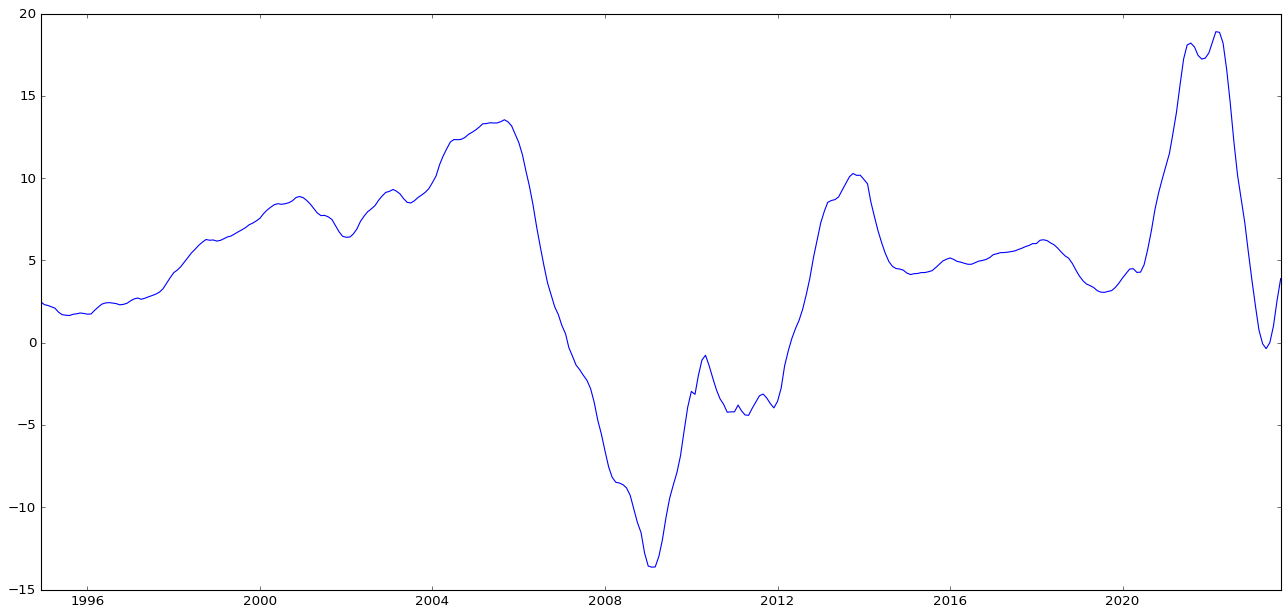

In [12]:
df_data["CSUSHPINSA"].plot()

In [4]:
# ---------------------------------- #
#--- Factor MA (MAF) --------------- #
# ---------------------------------- #
#? Expliqué dans l'article: 
#? au lieu d'utiliser x(t), x(t-1), x(t-3) ... x(t-p) comme variables dans le dataset on utilise juste la sortie de factorMA(p=p) 
#? qui résume l'info contenue dans x(t), x(t-1), x(t-3) ... x(t-p) en (ici) 3 principal components 

def factorMA(ts,p=12):
    x = ts.copy()
    
    name = ts.columns[0]
    for i in range(1,p+1):
        x[f"{name}_{i}"] = ts.shift(i)[name]
    x = x.dropna()
    std_x = x - x.mean(axis = 0)
    covariance_matrix = np.cov(std_x, ddof = 1, rowvar = False)
    res = pd.DataFrame(index=x.index)
    
    #* >PCA
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    order_of_importance = np.argsort(eigenvalues)[::-1] 
    # utilize the sort order to sort eigenvalues and eigenvectors
    sorted_eigenvalues = eigenvalues[order_of_importance]
    sorted_eigenvectors = eigenvectors[:,order_of_importance]
    # 3 MAFs
    for i in range(0,3):
        res[f'{name}_PCA{i}'] = pd.DataFrame(np.asarray(std_x) @ np.asarray(sorted_eigenvectors[i]),index=x.index).values
    return res

# ---------------------------------- #

def usual_PCA(df):
    x = df.copy()
    res = pd.DataFrame(index=df.index)
    std_x = x - x.mean(axis = 0)
    covariance_matrix = np.cov(std_x, ddof = 1, rowvar = False)
    #* >PCA
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    order_of_importance = np.argsort(eigenvalues)[::-1] 
    sorted_eigenvalues = eigenvalues[order_of_importance]
    sorted_eigenvectors = eigenvectors[:,order_of_importance]
    for i in range(0,5):
        res[f'PCA{i}'] = pd.DataFrame(np.asarray(std_x) @ sorted_eigenvectors[:,i],index=x.index)[0]
    return res

# ---------------------------------- #

# > MAF (PCA on p=12 lags for each variable, retrieve first 3 components)
for k in range(1,len(VARIABLES_LIST)):
    maf = factorMA(ts=df_data[[VARIABLES_LIST[k]]])
    df_data[list(maf.columns)] = maf 

# > Lags of dependent variable
for k in range(1,13):
    df_data[f"CSUSHPINSA-{k}"] = df_data["CSUSHPINSA"].shift(periods=k)
    
# >
for var in ["CPIAUCSL","DSPIC96","GDPr","SPREAD","MORTGAGE30US","UNRATE"]:
    df_data[f"{var}-1"] = df_data[f"{var}"].shift(periods=1)

df_data = df_data.dropna()
df_data

,CSUSHPINSA,CURRCIR,M2SL,CPIAUCSL,INDPRO,PCE,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,...,CSUSHPINSA-9,CSUSHPINSA-10,CSUSHPINSA-11,CSUSHPINSA-12,CPIAUCSL-1,DSPIC96-1,GDPr-1,SPREAD-1,MORTGAGE30US-1,UNRATE-1
1994-12-01,2.485715,9.625484,0.341910,2.564243,6.656124,5.749137,1.636100,1.257370,14.157203,-0.244470,...,2.542614,2.429406,2.332682,2.133645,2.569445,4.535572,3.429495,2.67,2.01,-1.0
1995-01-01,2.312001,9.747831,0.502348,2.830378,6.527564,5.641418,3.852642,1.947992,14.728222,0.358904,...,2.627580,2.542614,2.429406,2.332682,2.564243,1.636100,4.189494,2.36,2.03,-1.0
1995-02-01,2.260583,8.783234,0.407718,2.822768,6.355311,4.602537,3.862844,1.637996,14.582147,0.692778,...,2.788235,2.627580,2.542614,2.429406,2.830378,3.852642,4.228475,2.25,2.09,-1.0
1995-03-01,2.182795,8.728677,0.315584,2.749084,5.486476,5.024453,3.809877,1.847053,14.811590,1.234534,...,2.779777,2.788235,2.627580,2.542614,2.822768,3.862844,2.921890,1.55,1.68,-1.2
1995-04-01,2.097267,8.798456,0.512858,3.077166,4.726447,4.583861,3.067401,1.618147,14.702911,1.795001,...,2.758044,2.779777,2.788235,2.627580,2.749084,3.809877,3.123721,1.22,0.78,-1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,-0.361861,2.652660,-3.977345,4.045883,0.143023,5.717823,4.844180,1.675374,5.540991,-4.756079,...,12.193446,14.548122,16.572259,18.204098,4.838238,4.398008,1.985270,-1.37,1.36,-0.3
2023-06-01,0.006163,2.803391,-3.817907,3.045164,-0.376708,5.192728,5.164560,1.601335,5.088911,-4.256655,...,10.158814,12.193446,14.548122,16.572259,4.045883,4.844180,2.425365,-1.49,1.20,0.1
2023-07-01,0.985670,2.672625,-3.946734,3.245824,0.081221,5.749568,4.248202,1.656282,4.791489,-4.048647,...,8.755112,10.158814,12.193446,14.548122,3.045164,5.164560,2.653249,-1.33,1.19,0.0
2023-08-01,2.555826,2.416576,-3.927519,3.640429,-0.018019,5.280807,3.962187,1.679580,3.964809,-4.065942,...,7.288118,8.755112,10.158814,12.193446,3.245824,4.248202,3.265240,-1.22,1.43,0.0


In [13]:
# ================================== #
### Dependent Variable
Y_VAR = "CSUSHPINSA"
### Linear part
X_VAR = ["CSUSHPINSA-1","CSUSHPINSA-2","CSUSHPINSA-3","CPIAUCSL-1","DSPIC96-1","GDPr-1","SPREAD-1","MORTGAGE30US-1","UNRATE-1"]
### Exogenous Variables
S_VAR = [f"CSUSHPINSA-{i}" for i in range(1,13)] + [cols for cols in df_data.columns if "PCA" in cols]

# ================================== #
data_MRF = df_data.copy().reset_index(drop=True)
#data_MRF = data_MRF.reset_index()

# ================================== #
Y_pos = data_MRF.columns.get_loc(Y_VAR)
S_pos = [data_MRF.columns.get_loc(s) for s in S_VAR]
X_pos = [data_MRF.columns.get_loc(x) for x in X_VAR]

# ======= OOS-WINDOWS ============== #
k = 12
oos_pos = np.arange(len(data_MRF) - k, len(data_MRF))

In [14]:
data_MRF

,CSUSHPINSA,CURRCIR,M2SL,CPIAUCSL,INDPRO,PCE,DSPIC96,TTLHHM156N,TOTALSL,DPSACBW027SBOG,...,CSUSHPINSA-9,CSUSHPINSA-10,CSUSHPINSA-11,CSUSHPINSA-12,CPIAUCSL-1,DSPIC96-1,GDPr-1,SPREAD-1,MORTGAGE30US-1,UNRATE-1
0,2.485715,9.625484,0.341910,2.564243,6.656124,5.749137,1.636100,1.257370,14.157203,-0.244470,...,2.542614,2.429406,2.332682,2.133645,2.569445,4.535572,3.429495,2.67,2.01,-1.0
1,2.312001,9.747831,0.502348,2.830378,6.527564,5.641418,3.852642,1.947992,14.728222,0.358904,...,2.627580,2.542614,2.429406,2.332682,2.564243,1.636100,4.189494,2.36,2.03,-1.0
2,2.260583,8.783234,0.407718,2.822768,6.355311,4.602537,3.862844,1.637996,14.582147,0.692778,...,2.788235,2.627580,2.542614,2.429406,2.830378,3.852642,4.228475,2.25,2.09,-1.0
3,2.182795,8.728677,0.315584,2.749084,5.486476,5.024453,3.809877,1.847053,14.811590,1.234534,...,2.779777,2.788235,2.627580,2.542614,2.822768,3.862844,2.921890,1.55,1.68,-1.2
4,2.097267,8.798456,0.512858,3.077166,4.726447,4.583861,3.067401,1.618147,14.702911,1.795001,...,2.758044,2.779777,2.788235,2.627580,2.749084,3.809877,3.123721,1.22,0.78,-1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,-0.361861,2.652660,-3.977345,4.045883,0.143023,5.717823,4.844180,1.675374,5.540991,-4.756079,...,12.193446,14.548122,16.572259,18.204098,4.838238,4.398008,1.985270,-1.37,1.36,-0.3
342,0.006163,2.803391,-3.817907,3.045164,-0.376708,5.192728,5.164560,1.601335,5.088911,-4.256655,...,10.158814,12.193446,14.548122,16.572259,4.045883,4.844180,2.425365,-1.49,1.20,0.1
343,0.985670,2.672625,-3.946734,3.245824,0.081221,5.749568,4.248202,1.656282,4.791489,-4.048647,...,8.755112,10.158814,12.193446,14.548122,3.045164,5.164560,2.653249,-1.33,1.19,0.0
344,2.555826,2.416576,-3.927519,3.640429,-0.018019,5.280807,3.962187,1.679580,3.964809,-4.065942,...,7.288118,8.755112,10.158814,12.193446,3.245824,4.248202,3.265240,-1.22,1.43,0.0


In [15]:
# ================================== #
#TODO: /// MRF FIT ///
MRF_model = MRF.MacroRandomForest(data = data_MRF,
            y_pos = Y_pos,
            x_pos = X_pos,
            S_pos = S_pos,
            mtry_frac=0.15,
            B = 1000,
            parallelise = True,
            n_cores = -1,
            resampling_opt = 2,
            oos_pos = oos_pos,
            trend_push = 4,
            quantile_rate=None,
            ridge_lambda=0.001,
            subsampling_rate=0.75,
            rw_regul=0.75,
            print_b = True,
            fast_rw = True)

# ================================== #
#TODO: /// MRF training ///
MRF_output = MRF_model._ensemble_loop()

Tree 4 out of 1000
Tree 6 out of 1000
Tree 2 out of 1000
Tree 1 out of 1000
Tree 3 out of 1000
Tree 7 out of 1000
Tree 5 out of 1000
Tree 8 out of 1000
Tree 9 out of 1000
Tree 10 out of 1000
Tree 11 out of 1000
Tree 12 out of 1000
Tree 13 out of 1000
Tree 14 out of 1000
Tree 15 out of 1000
Tree 16 out of 1000
Tree 17 out of 1000
Tree 18 out of 1000
Tree 19 out of 1000
Tree 20 out of 1000
Tree 21 out of 1000
Tree 22 out of 1000
Tree 23 out of 1000
Tree 24 out of 1000
Tree 25 out of 1000
Tree 26 out of 1000
Tree 27 out of 1000
Tree 28 out of 1000
Tree 29 out of 1000
Tree 30 out of 1000
Tree 32 out of 1000
Tree 31 out of 1000
Tree 33 out of 1000
Tree 34 out of 1000
Tree 35 out of 1000
Tree 36 out of 1000
Tree 37 out of 1000
Tree 38 out of 1000
Tree 39 out of 1000
Tree 40 out of 1000
Tree 41 out of 1000
Tree 42 out of 1000
Tree 44 out of 1000
Tree 43 out of 1000
Tree 45 out of 1000
Tree 46 out of 1000
Tree 47 out of 1000
Tree 48 out of 1000
Tree 49 out of 1000
Tree 50 out of 1000
Tree 51 o

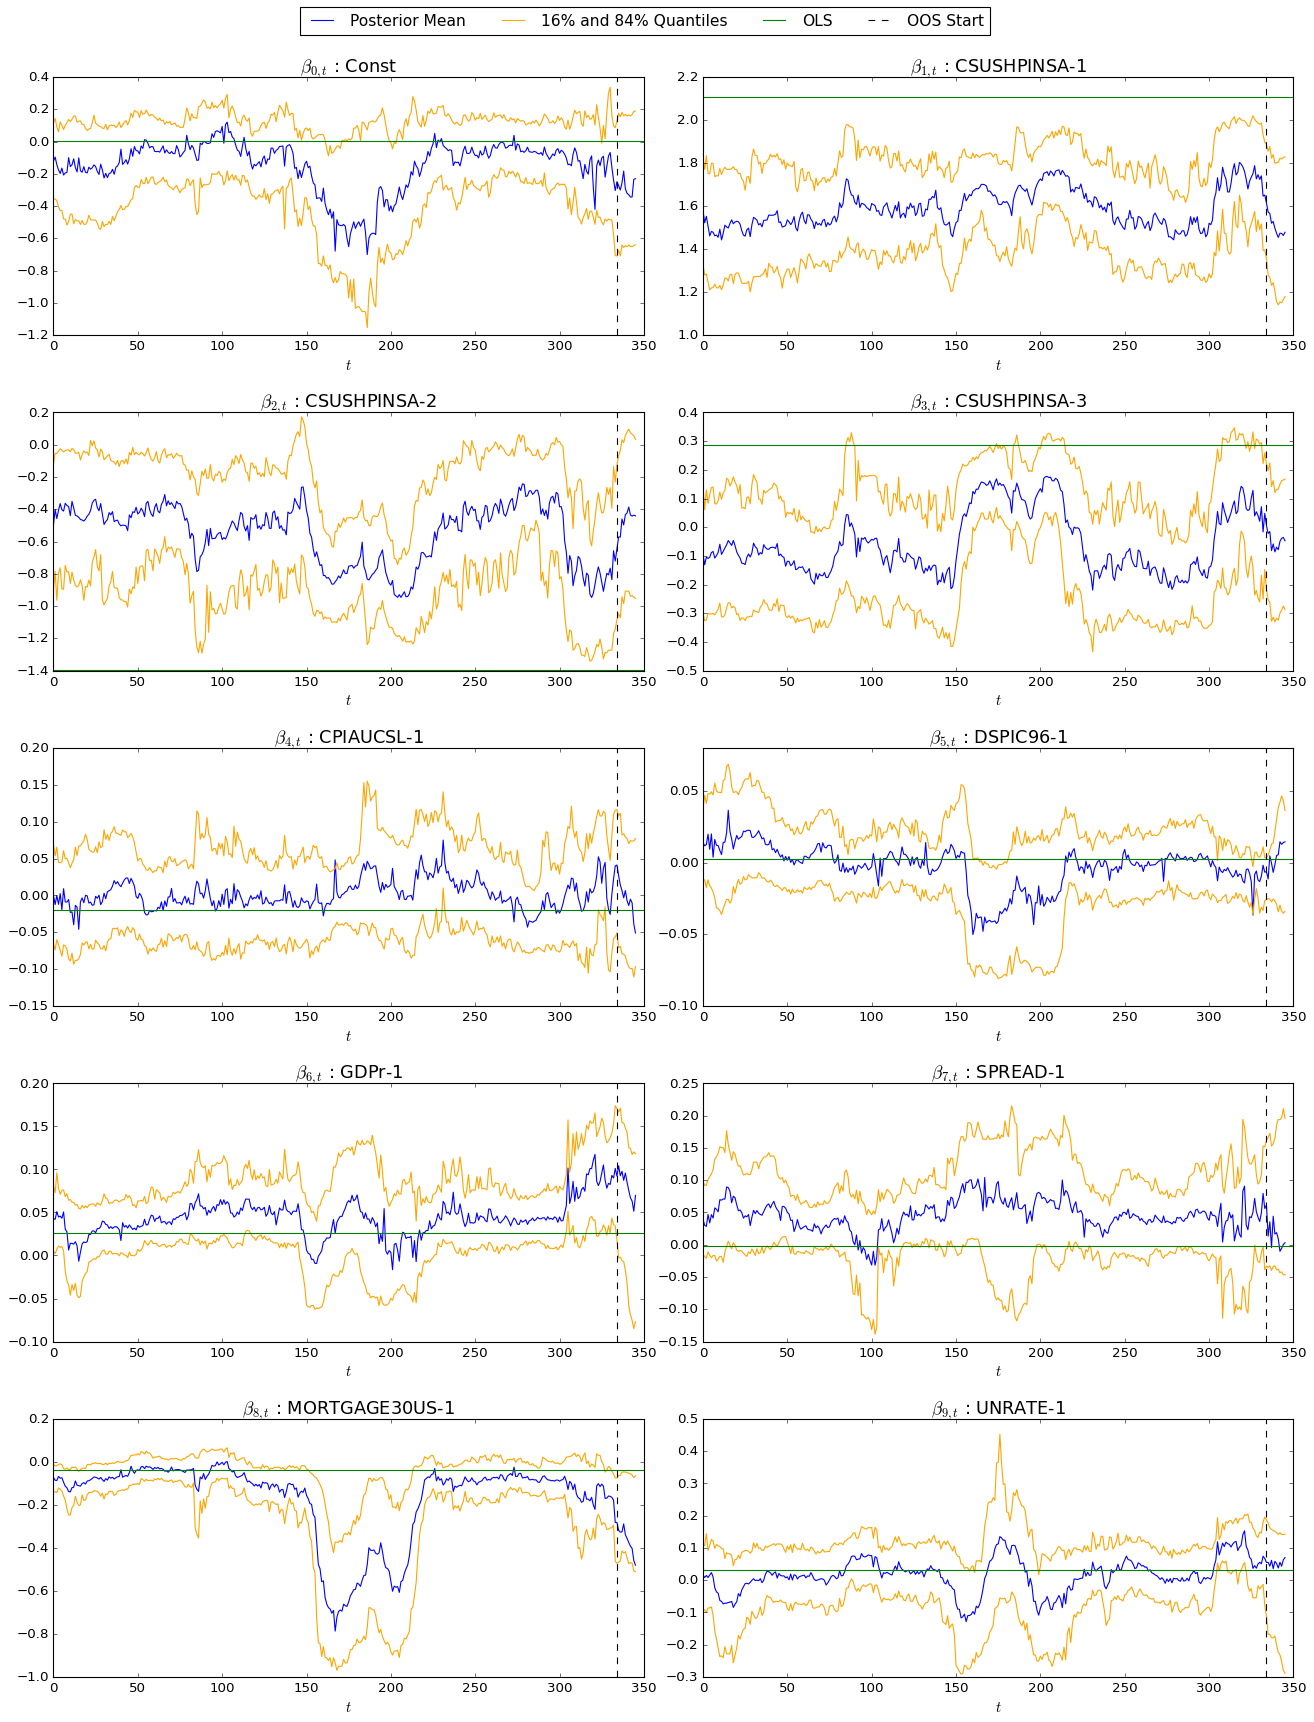

In [16]:
MRF_model.band_plots()

In [17]:
beta_res = pd.DataFrame(MRF_output['betas'],index=df_data.index,columns=['const']+X_VAR)
beta_res

,const,CSUSHPINSA-1,CSUSHPINSA-2,CSUSHPINSA-3,CPIAUCSL-1,DSPIC96-1,GDPr-1,SPREAD-1,MORTGAGE30US-1,UNRATE-1
1994-12-01,-0.122343,1.580411,-0.499151,-0.094095,0.000080,0.014219,0.042945,0.039883,-0.072169,0.015996
1995-01-01,-0.096203,1.522402,-0.401549,-0.131133,-0.012430,0.011787,0.041973,0.030113,-0.085268,0.008429
1995-02-01,-0.143508,1.552290,-0.457897,-0.104695,-0.000178,0.012596,0.050982,0.028428,-0.086205,0.014754
1995-03-01,-0.175815,1.505079,-0.406197,-0.108958,-0.012066,0.019849,0.044734,0.046879,-0.067315,0.008401
1995-04-01,-0.198094,1.460911,-0.364935,-0.104879,0.002444,0.009358,0.045835,0.033762,-0.075493,0.016281
...,...,...,...,...,...,...,...,...,...,...
2023-05-01,-0.329546,1.454088,-0.386331,-0.078763,-0.013663,0.005505,0.075716,0.009336,-0.374288,0.038049
2023-06-01,-0.344411,1.473689,-0.434858,-0.049537,-0.005069,0.014560,0.067119,-0.010176,-0.391613,0.055813
2023-07-01,-0.343643,1.472641,-0.442973,-0.038630,-0.010165,0.012783,0.063229,-0.005586,-0.402164,0.043475
2023-08-01,-0.233708,1.463139,-0.436628,-0.035841,-0.038961,0.014011,0.051422,0.000378,-0.458494,0.063081


In [23]:
fit_res = pd.DataFrame(index=beta_res.index)
for x in X_VAR:
    fit_res[x] = beta_res[x]*df_data[x]
fit_res['const'] = beta_res['const']

fit_res['fitted'] = fit_res.sum(axis=1)
fit_res['actual'] = df_data[Y_VAR]
fit_res

,CSUSHPINSA-1,CSUSHPINSA-2,CSUSHPINSA-3,CPIAUCSL-1,DSPIC96-1,GDPr-1,SPREAD-1,MORTGAGE30US-1,UNRATE-1,const,fitted,actual
1994-12-01,3.992662,-1.343112,-0.254280,0.000205,0.064491,0.147280,0.106487,-0.145059,-0.015996,-0.122343,2.430335,2.485715
1995-01-01,3.784256,-1.014451,-0.352850,-0.031874,0.019284,0.175844,0.071068,-0.173094,-0.008429,-0.096203,2.373552,2.312001
1995-02-01,3.588895,-1.138202,-0.264495,-0.000504,0.048529,0.215575,0.063964,-0.180168,-0.014754,-0.143508,2.175332,2.260583
1995-03-01,3.402356,-0.939128,-0.270837,-0.034061,0.076675,0.130707,0.072662,-0.113089,-0.010081,-0.175815,2.139388,2.182795
1995-04-01,3.188870,-0.824966,-0.242480,0.006718,0.035653,0.143177,0.041189,-0.058885,-0.017909,-0.198094,2.073273,2.097267
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,-0.098838,-0.295707,-0.168503,-0.066107,0.024213,0.150316,-0.012790,-0.509032,-0.011415,-0.329546,-1.317408,-0.361861
2023-06-01,-0.533271,0.029558,-0.037917,-0.020508,0.070531,0.162789,0.015162,-0.469936,0.005581,-0.344411,-1.122421,0.006163
2023-07-01,0.009076,0.160295,0.002626,-0.030955,0.066020,0.167761,0.007429,-0.478575,0.000000,-0.343643,-0.439966,0.985670
2023-08-01,1.442173,-0.002691,0.012970,-0.126460,0.059522,0.167906,-0.000462,-0.655647,0.000000,-0.233708,0.663603,2.555826


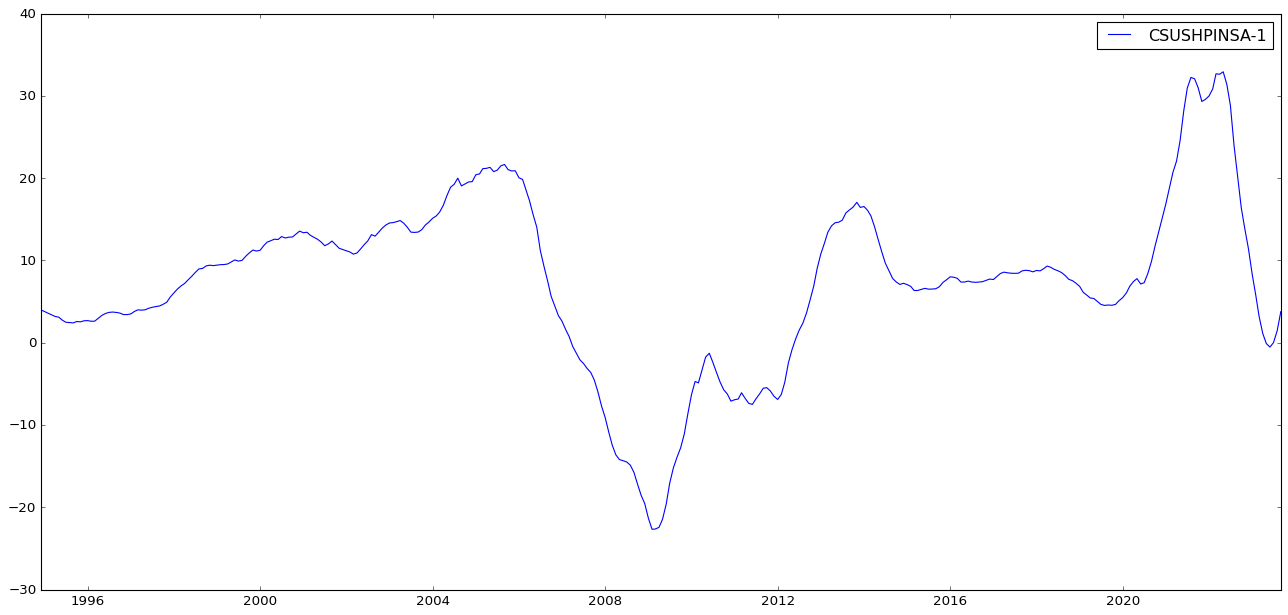

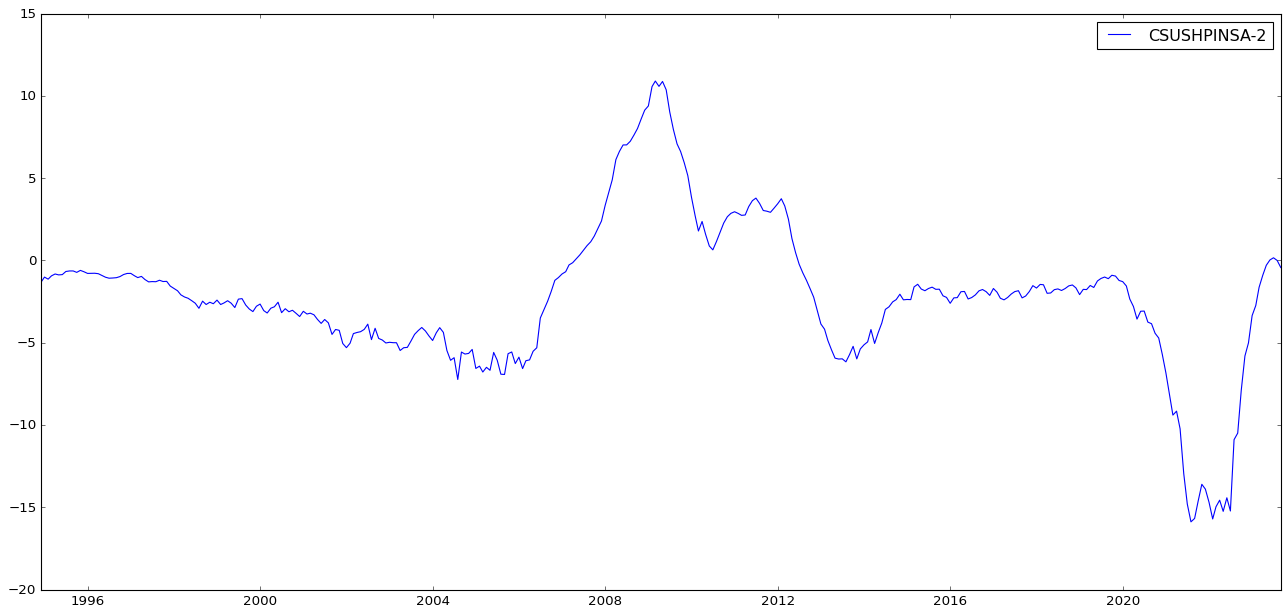

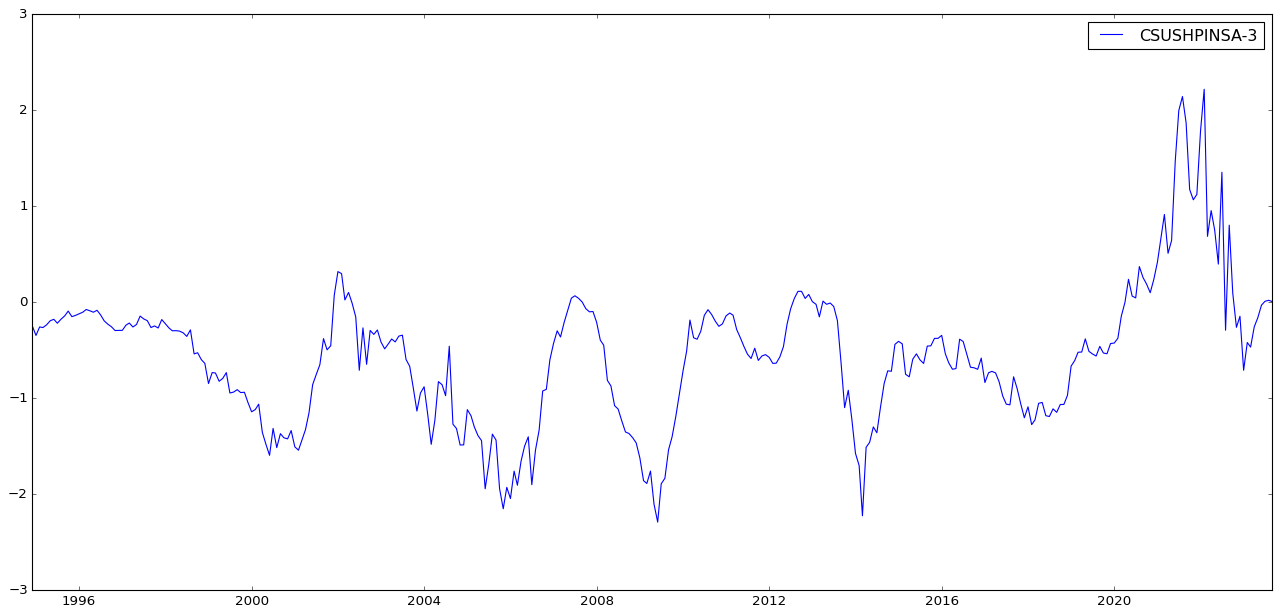

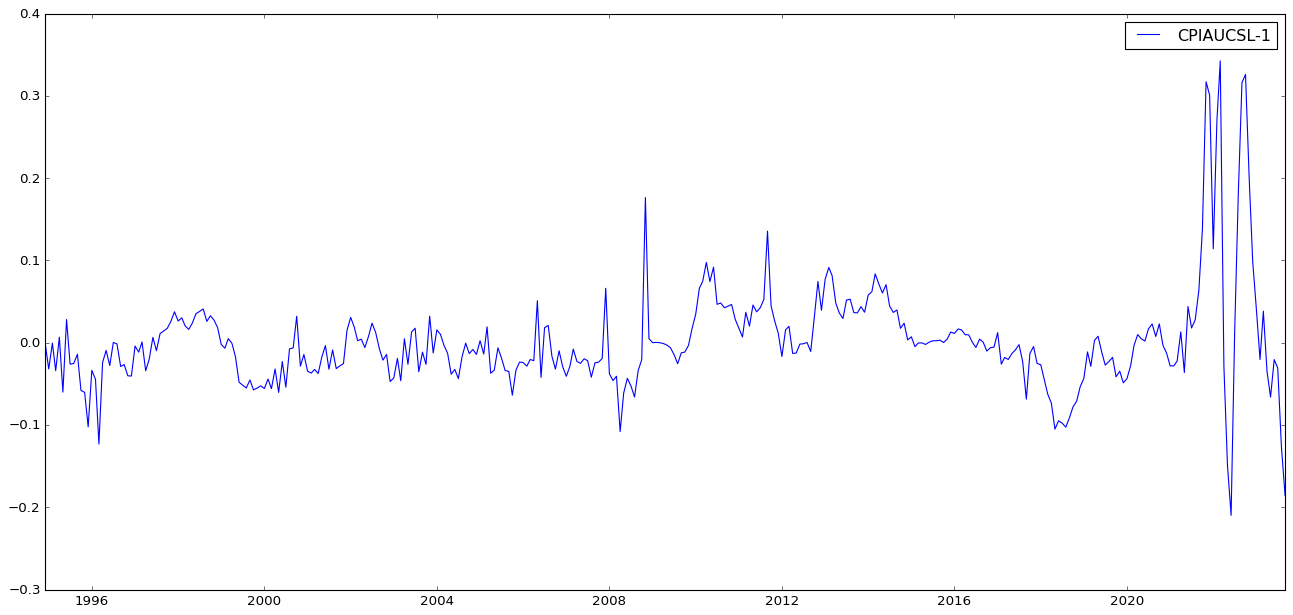

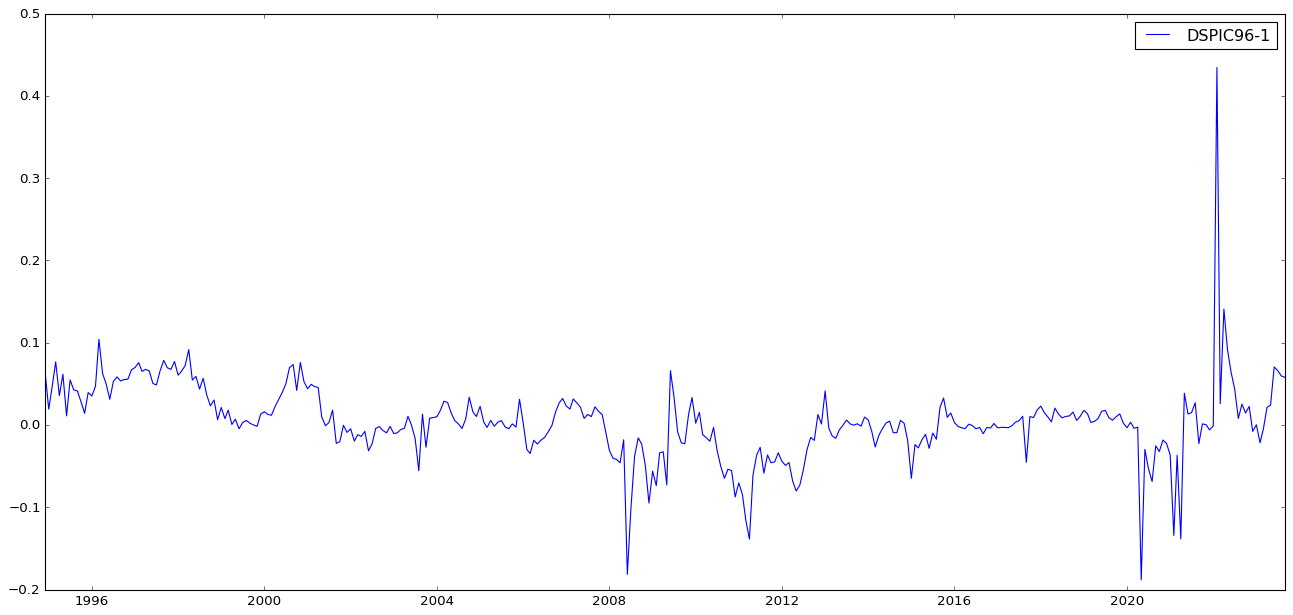

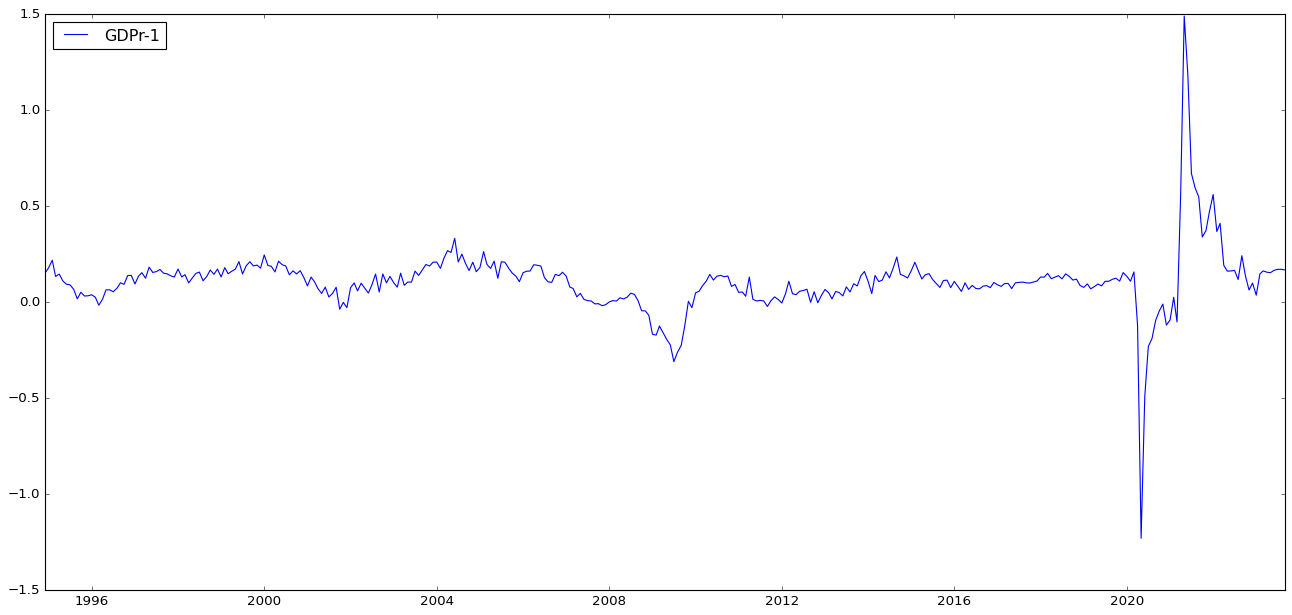

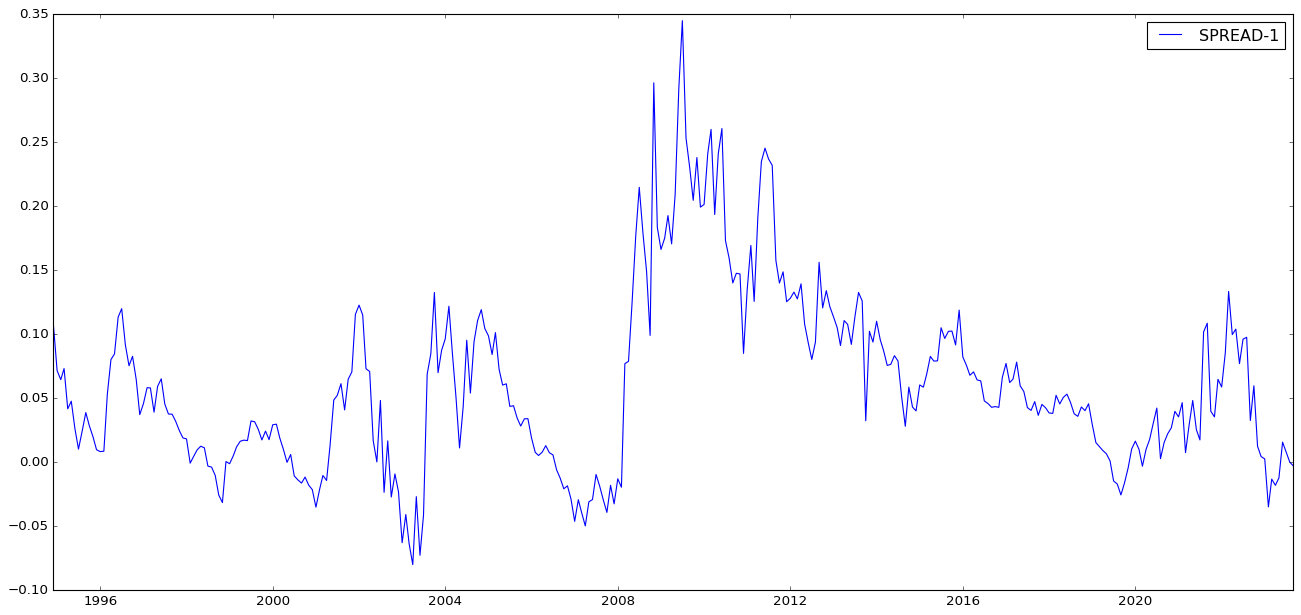

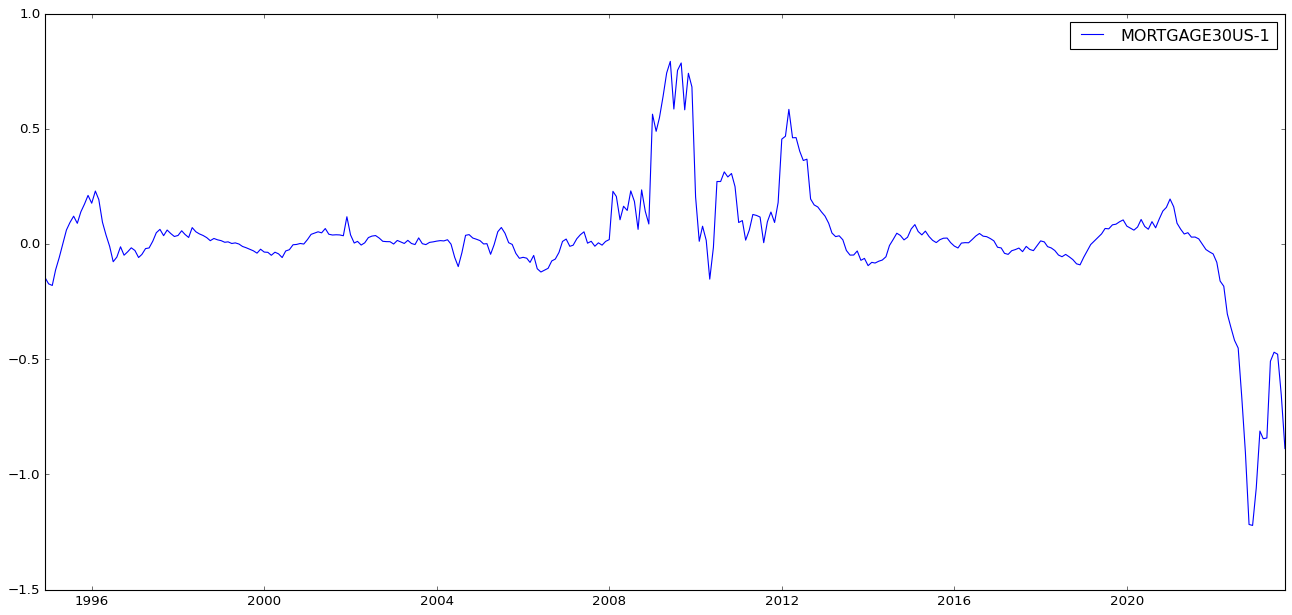

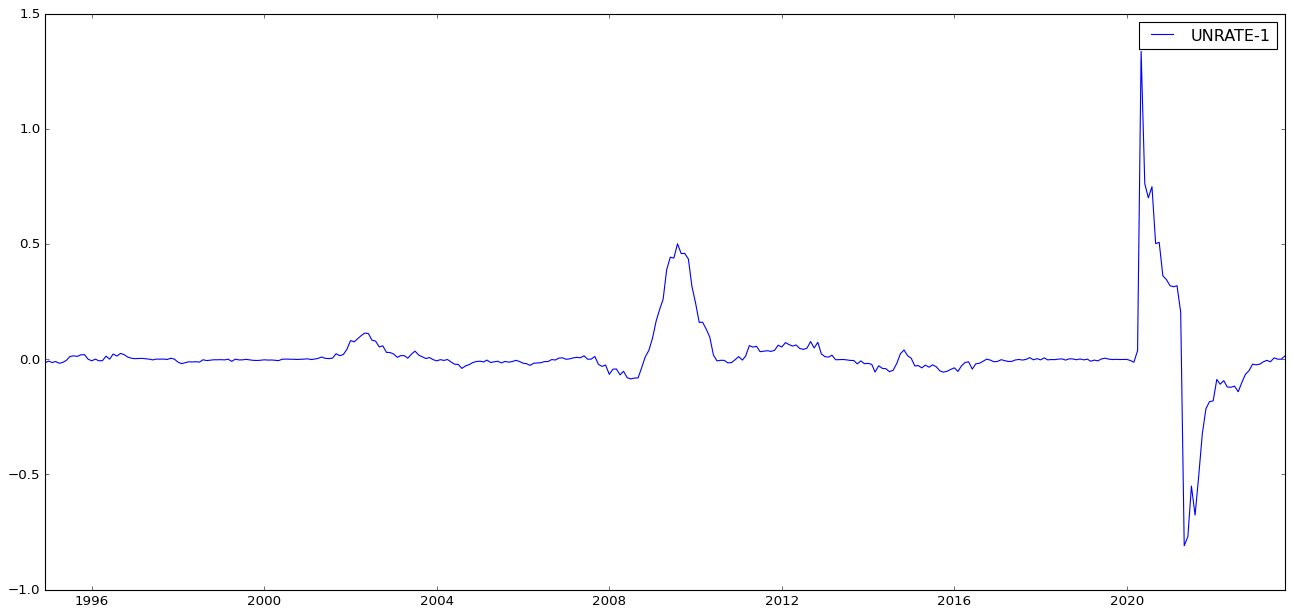

In [30]:
for x in X_VAR:
    fit_res[[x]].plot()

<Axes: >

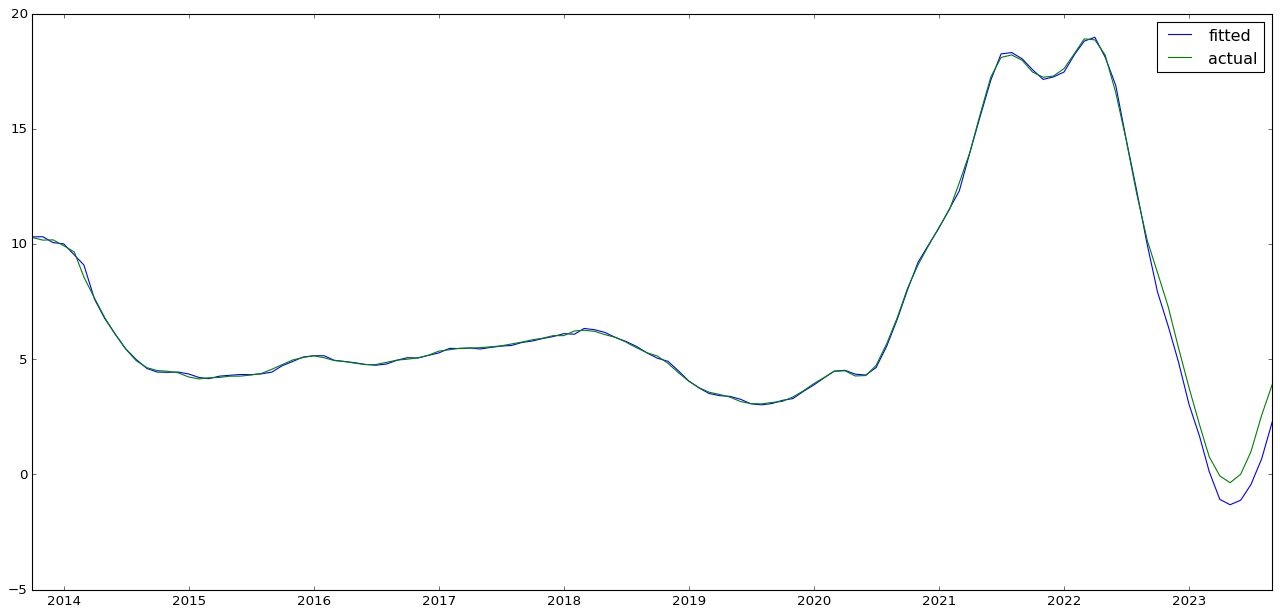

In [28]:
fit_res[['fitted','actual']].tail(120).plot()